In [1]:
import numpy as np
import selfies as sf 
import os
import sys
import multiprocessing as mp
from functools import partial
import json 
from rdkit import Chem
from rdkit.Chem import AllChem
from io import StringIO
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
Chem.WrapLogs()
IPythonConsole.ipython_useSVG=False

In [2]:

def selfies_split(selfies):
    return selfies.replace(']', '] ').split()

def find_int(token):
    for character in token:
                if character.isdigit():
                    return int(character)
                else:
                    pass

def get_numeric_value(token):
    num_dict={
        "[C]" : 0,
        "[Ring1]" : 1,
        "[Ring2]" : 2,
        "[Branch1]" : 3,
        "[=Branch1]" : 4,
        "[#Branch1]" : 5,
        "[Branch2]" : 6,
        "[=Branch2]" : 7,
        "[#Branch2]" : 8,
        "[O]" : 9,
        "[N]" : 10,
        "[=N]" : 11,
        "[=C]" : 12,
        "[#C]" : 13,
        "[S]" : 14,
        "[P]" : 15
    }
    value = num_dict[token]
    return value

def calculate_len_connect(i,nb_num_token,selfies_token):
    num=0
    skip_idx=[]
    for j in range(1,nb_num_token+1):
        skip_idx.append(i+j)
        num+=get_numeric_value(selfies_token[i+j]) * (16**(nb_num_token-j))
    num+=1
    return num,skip_idx

def token_classify (selfies_token):
    
    ### initialization of lists
    atoms_idx_list=[]
    branch_idx_list=[]
    ring_idx_list=[]
    skip_list=[]

    for i,token in enumerate(selfies_token):
        if i in skip_list:
            continue

        if token.find("Branch") !=-1:
            nb_num_token=find_int(token)
            num,skip_idx=calculate_len_connect(i,nb_num_token,selfies_token)
            skip_list.extend(skip_idx)
            branch_idx_list.append([i,nb_num_token,num])

        elif token.find("Ring")!=-1:
            nb_num_token= find_int(token)
            num,skip_idx=calculate_len_connect(i,nb_num_token,selfies_token)
            skip_list.extend(skip_idx)
            ring_idx_list.append([i,nb_num_token,num])

        else:
          atoms_idx_list.append(i)  
    
    return atoms_idx_list,branch_idx_list,ring_idx_list

def find_start_ring(start_token_idx,ring_length,atoms_idx_list):
    start_position=-1
    if start_token_idx> atoms_idx_list[-1]:
        start_index=len(atoms_idx_list)-1-ring_length-1
        start_position=atoms_idx_list[start_index]
        return start_position
    else:
        for relative_index,atoms_index in enumerate(atoms_idx_list):
            if atoms_index< start_token_idx:
                pass
            else:
                start_index=relative_index-ring_length-1
                start_position=atoms_idx_list[start_index]
                break
        return start_position

def find_ring_coord(ring_idx_list,atoms_idx_list):
    pre_ring_block=[]
    for ring_group in ring_idx_list:
        start_token_idx=ring_group[0]
        nb_num_token=ring_group[1]
        ring_length=ring_group[2]
        start_position=find_start_ring(start_token_idx,ring_length,atoms_idx_list)
        end_position=start_token_idx +nb_num_token
        pre_ring_block.append([start_position,end_position])
    return pre_ring_block 

def find_branch_coord(branch_idx_list):

    pre_branch_block=[]
    for branch_group in branch_idx_list:
        
        start_token_idx=branch_group[0]
        nb_num_token=branch_group[1]
        branch_length=branch_group[2]
        
        end_position=start_token_idx+nb_num_token+ branch_length
        start_position=start_token_idx-1

        if pre_branch_block:
            if pre_branch_block[-1][1] == start_position:
                start_position=pre_branch_block[-1][0]
                pre_branch_block.pop()
            else:
                pass
        else:
            pass
        pre_branch_block.append([start_position,end_position])
    
    return pre_branch_block  

class Solution: 
   def solve(self, intervals):            
       intervals.sort() 
       ans = [] 
       for s, e in intervals: 
         if ans and s <= ans[-1][1]: 
            ans[-1][1] = max(ans[-1][1], e) 
         else: 
            ans.append([s, e]) 
       return ans 

def group(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

def get_index_main_chain(len_selfies,pre_block_list):
  idx_all_selfies=list(range(len_selfies))
  all_blocks_idx=[]
  for block in pre_block_list:
    temp=list(range(block[0],block[1]+1) ) 
    all_blocks_idx.extend(temp)
  all_blocks_idx=set(all_blocks_idx)
  main_chain_idx=[i for i in idx_all_selfies if i not in all_blocks_idx]
  if  len(main_chain_idx)==0 :
    return None
  elif len(main_chain_idx)==1:
    main_chain_block=[[main_chain_idx[0],main_chain_idx[0]]]
    return main_chain_block

  else:
    temp=list(group(main_chain_idx))
    main_chain_block= [list(tuple_) for tuple_ in temp]
    return main_chain_block

def find_block(selfies_token,atoms_idx_list,branch_idx_list,ring_idx_list):
  pre_branch_block=find_branch_coord(branch_idx_list)
  pre_ring_block=find_ring_coord(ring_idx_list,atoms_idx_list)
  pre_block= pre_branch_block + pre_ring_block
  ob= Solution()
  pre_block_list=ob.solve(pre_block)
  main_blocks=get_index_main_chain(len(selfies_token),pre_block_list)
  if main_blocks :
    block_list=pre_block_list +  main_blocks
    orderded_block_list=ob.solve(block_list)
    selfies_frag_list=["".join(selfies_token[block[0]:block[1]+1]) for block in orderded_block_list]
    return selfies_frag_list
  elif len(pre_block)>1:
    orderded_block_list=pre_block_list
    selfies_frag_list=["".join(selfies_token[block[0]:block[1]+1]) for block in orderded_block_list]
    return selfies_frag_list    
  else:
    return None

def process_selfies(selfies):
    tokens=selfies_split(selfies)
    atoms_idx_list,branch_idx_list,ring_idx_list=token_classify(selfies_token=tokens)
    selfies_frag=find_block(tokens,atoms_idx_list,branch_idx_list,ring_idx_list)
    return selfies_frag


In [3]:
def block_quality_control(block):
    ### assess insertability 
    new_block="[C]"+block+"[C]"
    smi=sf.decoder(new_block)
    temp_block=sf.encoder(smi)
    if new_block==temp_block:
        ### assess generability 
        mol=Chem.MolFromSmiles(smi)
        sio = sys.stderr = StringIO()
        AllChem.EmbedMolecule(mol)
        error_log =sio.getvalue()
        if error_log:
            return False
        else:
            return True
    else:
        return False

def compute_blocks_quality(blocks):
    return np.sum(np.array([block_quality_control(block) for block in blocks]))

def assess_blocks(smiles):
    
    ### try to get blocks
    selfies=sf.encoder(smiles)
    try :
        blocks=process_selfies(selfies)
    except:
        return [0,None]
    
    ### test if blocks are good 
    nb_blocks= len(blocks)
    if nb_blocks== compute_blocks_quality(blocks):
        return [nb_blocks,blocks]
    else:
        return [0,None]
    

In [8]:
def block_quality_control(block,max_length):

    ### assess if nb of tokens below or equal  to threshold 
    if len(selfies_split(block)) > max_length:
        return False
    else:
        
        ### assess insertability 
        new_block="[C]"+block+"[C]"
        smi=sf.decoder(new_block)
        temp_block=sf.encoder(smi)
        if new_block==temp_block:
            
            ### assess generability 
            mol=Chem.MolFromSmiles(smi)
            sio = sys.stderr = StringIO()
            AllChem.EmbedMolecule(mol)
            error_log =sio.getvalue()
            if error_log:
                return False
            else:
                
                return True
        else:
            return False

def assess_blocks(smiles,max_length):
    
    ### try to get blocks
    selfies=sf.encoder(smiles)
    try :
        blocks=process_selfies(selfies)
    except:
        return [0,None]
    
    ### test if blocks are good 
    for block in blocks:
        if block_quality_control(block,max_length):
            pass
        else:
            return [0,None]
  
    return [len(blocks),blocks]

In [4]:
### modify as wished 
params={
    "input_smiles" : "CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)N)C(F)(F)F",
    "nb_random_SMILES" : 1000000,
    "output_dir" : "./",
    "name" : "celecoxib",
    'nb_max_tokens' : 25
}

In [5]:
start_mol= Chem.MolFromSmiles(params["input_smiles"])
Chem.Kekulize(start_mol)
set_random_smiles=set(Chem.MolToRandomSmilesVect(start_mol,params["nb_random_SMILES"],randomSeed=4))
list_random_smiles= list(set_random_smiles)


In [159]:
results = [assess_blocks(smi,max_length=params['nb_max_tokens']) for smi in list_random_smiles]

3.56 s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
def get_unique_rand_smiles(seed_number,mol,nb_random_smiles):
    return list(set(Chem.MolToRandomSmilesVect(mol,nb_random_smiles)))

In [7]:
with mp.Pool(mp.cpu_count()-2) as pool:
    random_smiles_list= pool.map(partial(get_unique_rand_smiles,mol=start_mol,nb_random_smiles=params["nb_random_SMILES"]),list(range(10)))
    pool.close()
    pool.join()

In [8]:
with mp.Pool(mp.cpu_count()) as pool :
    results=pool.map(assess_blocks,list_random_smiles)
    pool.close()
    pool.join()

[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20] UFFTYPER: Unrecognized atom type: S_5+6 (1)
[15:07:20]

In [160]:

results= [[0,None] for _ in range(10000)]

In [9]:
nb_blocks_list,blocks_list= zip(*results)
nb_blocks_list= np.array(nb_blocks_list)
longuest_blocks=[blocks for i,blocks in enumerate(blocks_list) if nb_blocks_list[i]==nb_blocks_list.max()]

In [10]:
nb_blocks_list,blocks_list= zip(*results)
nb_blocks_list= np.array(nb_blocks_list)
good_block= blocks_list[nb_blocks_list.argmax()]

In [11]:
good_block

['[O]',
 '[=S][=Branch1][C][=O][Branch1][C][N]',
 '[C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1]',
 '[N][N][=C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][C][=C][Ring1][=Branch2]',
 '[C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1]',
 '[C]']

In [12]:
len(longuest_blocks)

12

In [13]:
def get_unique_blocks_combinaison(blocks_list):
    unique_selfies= {}
    unique_combinaison=[]
    for blocks_combinaison in blocks_list:
        selfies= "".join(blocks_combinaison)
        if selfies not in unique_selfies:
            unique_selfies[selfies] = 1
            unique_combinaison.append(blocks_combinaison)
        else:
            unique_selfies[selfies]+=1
    return unique_combinaison,unique_selfies


In [14]:
unique_combinaison,unique_selfies= get_unique_blocks_combinaison(longuest_blocks)

In [15]:
len(unique_selfies)

12

In [30]:
combinaison_index=4

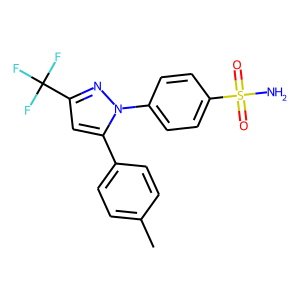

In [25]:
Draw.MolToImage(start_mol, subImgSize=(800,800))

looking at combination n°4


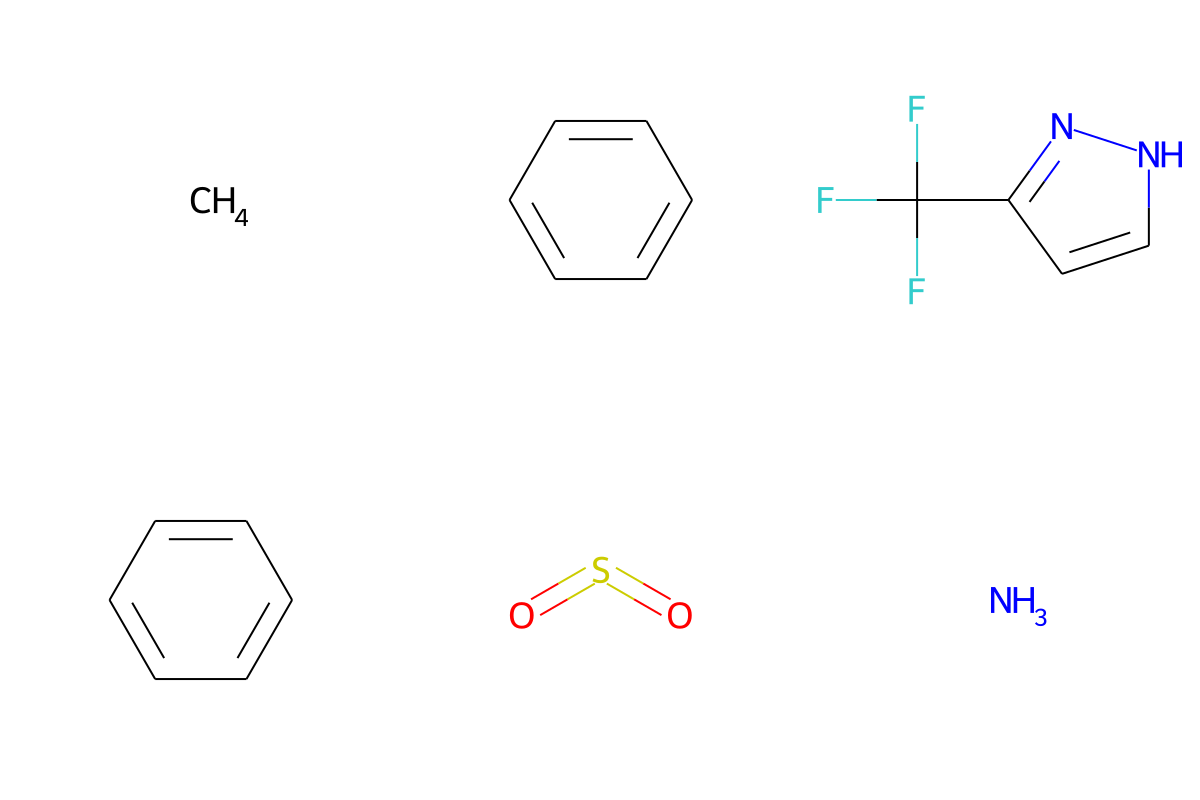

In [31]:
print(f"looking at combination n°{combinaison_index}")
temp_blocks= unique_combinaison[combinaison_index]
block_2D_list= [Chem.MolFromSmiles(sf.decoder(block)) for block in temp_blocks]
# block_2D_list.append(start_mol)
if combinaison_index == len(unique_combinaison)-1:
    combinaison_index=0
else:
    combinaison_index+=1

Draw.MolsToGridImage(block_2D_list,molsPerRow=3,subImgSize=(400,400))



In [112]:
combinaison_index = 0
os.makedirs(params["output_dir"],exist_ok=True)
output_path= os.path.join(params["output_dir"],f'{params["name"]}_starting_blocks.json')
with open(output_path,"w") as json_file:
    json.dump(unique_combinaison[combinaison_index],json_file)
    json_file.close()